## BLSTM with SEQ_LEN 60 partially removed stopwords

In [1]:
import pandas as pd
import numpy as np
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Embedding, CuDNNLSTM, Bidirectional
from keras.optimizers import Adam, Adagrad

C:\Users\Aman Deep Singh\Anaconda3\envs\tf-gpu\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
# F1 metrics function
def f1(y_true, y_pred):
    '''returns the f1 score given targets and predictions'''
    
    def recall(y_true, y_pred):
        true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
        rec = true_pos / (possible_pos + K.epsilon())
        return rec
    
    def precision(y_true, y_pred):
        true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
        prec = true_pos / (predicted_pos + K.epsilon())
        return prec
    
    _precision = precision(y_true, y_pred)
    _recall = recall(y_true, y_pred)
    return 2 * ((_precision * _recall) / (_precision + _recall + K.epsilon()))

In [3]:
df = pd.read_csv('D:/Datasets/hackerearth/hm_train.csv')
df.drop(['num_sentence'], axis=1, inplace=True)
labels = df.predicted_category
df.drop(['predicted_category'], axis=1, inplace=True)

print(df.shape, len(labels))

(60321, 3) 60321


In [4]:
df.head()

,hmid,reflection_period,cleaned_hm
0,27673,24h,I went on a successful date with someone I fel...
1,27674,24h,I was happy when my son got 90% marks in his e...
2,27675,24h,I went to the gym this morning and did yoga.
3,27676,24h,We had a serious talk with some friends of our...
4,27677,24h,I went with grandchildren to butterfly display...


In [5]:
df.cleaned_hm = df.cleaned_hm.str.lower()

In [6]:
SEQ_LEN = 60
EPOCHS = 20

In [7]:
def remove_stopwords(sentence):
    # removing some known errors and differences between american and british english
    sentence = sentence.replace("\n", " ").replace(";", " ; ").replace(":", " : ").replace(",", " , ").replace(".", " . ").replace("?", " ? ").replace("/", " / ").replace("\\", " \ ").replace("'s", "").replace("n't", " not").replace("travelled", "traveled").replace("traveller", "traveler").replace("cancelled", "canceled").replace("favourite", "favorite").replace("i'm", "i am").replace("i've", "i have").replace("colour", "color").replace("neighbour", "neighbor").replace("jewellery", "jewelry").replace("theatre", "theater").replace("i'd", "i would").replace("didnt", "did not").replace("doesnt", "does not").replace("wasnt", "was not").replace("programme", "program").replace("organise", "organize")
    
    split = sentence.split()
    if len(split) > SEQ_LEN:
        return ' '.join([w for w in sentence.split() if w not in stopwords.words('english')])
    else:
        return sentence

In [ ]:
def completely_remove_stopwords(sentence):
    sentence = sentence.replace("\n", " ").replace(";", " ; ").replace(":", " : ").replace(",", " , ").replace(".", " . ").replace("?", " ? ").replace("/", " / ").replace("\\", " \ ").replace("'s", "").replace("n't", " not").replace("travelled", "traveled").replace("favourite", "favorite").replace("i'm", "i am").replace("i've", "i have").replace("colour", "color").replace("neighbour", "neighbor").replace("jewellery", "jewelry").replace("theatre", "theater").replace("i'd", "i would").replace("didnt", "did not").replace("doesnt", "does not").replace("wasnt", "was not").replace("programme", "program").replace("organise", "organize")
    
    return ' '.join([w for w in sentence.split() if w not in stopwords.words('english')])

In [8]:
df['cleaned_hm2'] = df.cleaned_hm.apply(remove_stopwords)

In [9]:
df.drop(['cleaned_hm'], axis=1, inplace=True)

In [10]:
df.head()

,hmid,reflection_period,cleaned_hm2
0,27673,24h,i went on a successful date with someone i fel...
1,27674,24h,i was happy when my son got 90% marks in his e...
2,27675,24h,i went to the gym this morning and did yoga .
3,27676,24h,we had a serious talk with some friends of our...
4,27677,24h,i went with grandchildren to butterfly display...


In [11]:
t = Tokenizer()
t.fit_on_texts(df.cleaned_hm2)
VOCAB_SIZE = len(t.word_index) + 1

In [12]:
encoded_train_set = t.texts_to_sequences(df.cleaned_hm2)
len(encoded_train_set)

60321

In [13]:
lengths = []
for doc in encoded_train_set:
    lengths.append(len(doc))

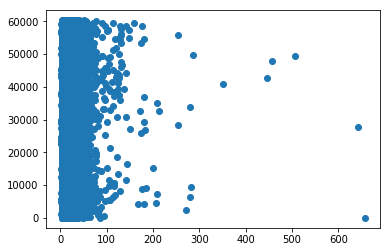

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(lengths, range(len(lengths)))
plt.show()

In [15]:
df['tokens'] = encoded_train_set

In [16]:
df.head()

,hmid,reflection_period,cleaned_hm2,tokens
0,27673,24h,i went on a successful date with someone i fel...,"[1, 21, 16, 3, 762, 314, 11, 282, 1, 90, 12593..."
1,27674,24h,i was happy when my son got 90% marks in his e...,"[1, 7, 12, 22, 2, 62, 17, 2277, 1423, 10, 80, ..."
2,27675,24h,i went to the gym this morning and did yoga .,"[1, 21, 4, 6, 393, 37, 91, 5, 101, 929]"
3,27676,24h,we had a serious talk with some friends of our...,"[25, 19, 3, 1615, 312, 11, 46, 48, 13, 4418, 1..."
4,27677,24h,i went with grandchildren to butterfly display...,"[1, 21, 11, 1903, 4, 3801, 4198, 20, 12595, 12..."


In [17]:
df.drop(['cleaned_hm2'], axis=1, inplace=True)

In [18]:
df.head()

,hmid,reflection_period,tokens
0,27673,24h,"[1, 21, 16, 3, 762, 314, 11, 282, 1, 90, 12593..."
1,27674,24h,"[1, 7, 12, 22, 2, 62, 17, 2277, 1423, 10, 80, ..."
2,27675,24h,"[1, 21, 4, 6, 393, 37, 91, 5, 101, 929]"
3,27676,24h,"[25, 19, 3, 1615, 312, 11, 46, 48, 13, 4418, 1..."
4,27677,24h,"[1, 21, 11, 1903, 4, 3801, 4198, 20, 12595, 12..."


In [19]:
np.mean(lengths)

17.21385587108967

In [20]:
padded_train_docs = pad_sequences(encoded_train_set, maxlen=SEQ_LEN, padding='post')

In [21]:
train_paddocs = []
for doc in padded_train_docs:
    train_paddocs.append(list(doc))

In [22]:
df['tokens2'] = train_paddocs

In [23]:
lengths = []
for doc in train_paddocs:
    lengths.append(len(doc))

In [24]:
np.mean(lengths)

60.0

In [25]:
df.drop(['tokens'], axis=1, inplace=True)

In [26]:
df.rename(index=str, columns={'tokens2': 'tokens'}, inplace=True)

In [27]:
df.head()

,hmid,reflection_period,tokens
0,27673,24h,"[1, 21, 16, 3, 762, 314, 11, 282, 1, 90, 12593..."
1,27674,24h,"[1, 7, 12, 22, 2, 62, 17, 2277, 1423, 10, 80, ..."
2,27675,24h,"[1, 21, 4, 6, 393, 37, 91, 5, 101, 929, 0, 0, ..."
3,27676,24h,"[25, 19, 3, 1615, 312, 11, 46, 48, 13, 4418, 1..."
4,27677,24h,"[1, 21, 11, 1903, 4, 3801, 4198, 20, 12595, 12..."


In [28]:
embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('D:/Datasets/embeddings/Word2Vec/GoogleNews-vectors-negative300.bin', binary=True)

In [29]:
VOCAB_SIZE

20810

In [30]:
embedding_matrix = np.zeros((VOCAB_SIZE, 300))
count = 0
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f'Did not find {word}')
        count += 1

count

Did not find a
Did not find to
Did not find and
Did not find of

Did not find 10
Did not find mturk
Did not find 24
Did not find 20
Did not find 100
Did not find 30
Did not find 15
Did not find 50
Did not find 12
Did not find 00
Did not find 2017
Did not find 25
Did not find 40
Did not find 11
Did not find 500
Did not find 13
Did not find 000
Did not find 200
Did not find i'll
Did not find donat
Did not find 14
Did not find 300
Did not find 60
Did not find travelling
Did not find judgements
Did not find 250
Did not find 18
Did not find 80
Did not find 10th
Did not find 1000
Did not find 45
Did not find 16
Did not find 70
Did not find 17
Did not find 90
Did not find morty
Did not find ooty
Did not find 2000
Did not find ps4
Did not find 75
Did not find fianca
Did not find 30th
Did not find eudaimonia
Did not find jigarthanda
Did not find a3i
Did not find iave
Did not find 2016
Did not find 150
Did not find 99
Did not find thatas
Did not find learnt
Did not find eudaimonic
Did not find w

Did not find 1987
Did not find 1980s
Did not find binghamton
Did not find hattiesburg
Did not find normandy
Did not find scranton
Did not find its'
Did not find ad'
Did not find 'true
Did not find detective'
Did not find cybrary
Did not find disucssing
Did not find mandarines
Did not find jobe
Did not find tohoshinki
Did not find colion
Did not find 514
Did not find ambitiousareal
Did not find videosaand
Did not find crisisawhen

Did not find 24h
Did not find yonex
Did not find lanudry
Did not find nths
Did not find zverev
Did not find dibels
Did not find playmateeeeee
Did not find jhon
Did not find gaffigan
Did not find asma
Did not find tastey
Did not find esport
Did not find 'dad'
Did not find krav
Did not find 'cold'
Did not find chappel
Did not find meditaion
Did not find wendt
Did not find wingstop
Did not find pollar
Did not find asteala
Did not find 2k8
Did not find individualas
Did not find rudolph
Did not find autry
Did not find godspell
Did not find daughn
Did not find chopi

Did not find ravelry
Did not find gernerally
Did not find assistising
Did not find nclex
Did not find 850
Did not find 992
Did not find beale
Did not find meiji
Did not find 'parent
Did not find date'
Did not find thishi
Did not find mignogna
Did not find abook
Did not find 405
Did not find nicu
Did not find lcsw
Did not find 'okay'
Did not find 3000cp
Did not find thorntons
Did not find 30s
Did not find uncc
Did not find mordor
Did not find keffir
Did not find nevgative
Did not find byoc
Did not find quakecon
Did not find '13
Did not find why'
Did not find valenties
Did not find bananna
Did not find porco
Did not find dualshock

Did not find smaug
Did not find jinga
Did not find dlorida
Did not find imperiale
Did not find levis
Did not find barkley
Did not find 565
Did not find cochin
Did not find 110km
Did not find alleppey
Did not find 140km
Did not find 04869
Did not find 222014
Did not find lakepalacethekkady
Did not find gaved
Did not find enjoed
Did not find remington
Did not fi

2687

In [31]:
embedding_matrix.shape

(20810, 300)

In [32]:
df['24h'] = df.reflection_period == '24h'
df['3m'] = df.reflection_period == '3m'

In [33]:
df.drop(['reflection_period'], axis=1, inplace=True)

In [34]:
df.head()

,hmid,tokens,24h,3m
0,27673,"[1, 21, 16, 3, 762, 314, 11, 282, 1, 90, 12593...",True,False
1,27674,"[1, 7, 12, 22, 2, 62, 17, 2277, 1423, 10, 80, ...",True,False
2,27675,"[1, 21, 4, 6, 393, 37, 91, 5, 101, 929, 0, 0, ...",True,False
3,27676,"[25, 19, 3, 1615, 312, 11, 46, 48, 13, 4418, 1...",True,False
4,27677,"[1, 21, 11, 1903, 4, 3801, 4198, 20, 12595, 12...",True,False


In [35]:
print(df.shape, len(labels))

(60321, 4) 60321


In [36]:
df.to_csv('D:/Datasets/hackerearth/hm_train-tok-nstp.csv')

In [37]:
labels_to_cats = {'achievement':      (1, 0, 0, 0, 0, 0, 0),
                  'affection':        (0, 1, 0, 0, 0, 0, 0),
                  'enjoy_the_moment': (0, 0, 1, 0, 0, 0, 0),
                  'nature':           (0, 0, 0, 1, 0, 0, 0),
                  'exercise':         (0, 0, 0, 0, 1, 0, 0),
                  'bonding':          (0, 0, 0, 0, 0, 1, 0),
                  'leisure':          (0, 0, 0, 0, 0, 0, 1)}

In [38]:
cats_to_labels = dict()
for k, v in labels_to_cats.items():
    cats_to_labels[v] = k

cats_to_labels

{(1, 0, 0, 0, 0, 0, 0): 'achievement',
 (0, 1, 0, 0, 0, 0, 0): 'affection',
 (0, 0, 1, 0, 0, 0, 0): 'enjoy_the_moment',
 (0, 0, 0, 1, 0, 0, 0): 'nature',
 (0, 0, 0, 0, 1, 0, 0): 'exercise',
 (0, 0, 0, 0, 0, 1, 0): 'bonding',
 (0, 0, 0, 0, 0, 0, 1): 'leisure'}

In [39]:
y = []
for label in labels:
    y.append(labels_to_cats[label])

y = np.array(y)
len(y)

60321

In [40]:
len(df.tokens[0])

60

In [41]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model = Model(input_tensor, x)

In [42]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', f1])

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 300)           6243000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 512)           1142784   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 256)           657408    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total para

In [44]:
x_train, x_val, y_train, y_val = train_test_split(df, y, test_size=0.2)

In [45]:
print(x_train.shape, x_val.shape)

(48256, 4) (12065, 4)


In [46]:
print(y_train.shape, y_val.shape)

(48256, 7) (12065, 7)


In [47]:
x_train_reshape = x_train.copy()
x_train_reshape = x_train_reshape.tokens

In [48]:
x_train_new = []
for element in x_train_reshape:
    x_train_new.append(np.array(element))
x_train_new = np.array(x_train_new)
x_train_new.shape

(48256, 60)

In [49]:
x_val_reshape = x_val.copy()
x_val_reshape = x_val_reshape.tokens

In [50]:
x_val_new = []
for element in x_val_reshape:
    x_val_new.append(np.array(element))
x_val_new = np.array(x_val_new)
x_val_new.shape

(12065, 60)

In [51]:
model.fit(x_train_new, y_train, epochs=EPOCHS, verbose=2)

Epoch 1/20
 - 50s - loss: 0.6940 - acc: 0.7658 - f1: 0.7310
Epoch 2/20
 - 52s - loss: 0.4377 - acc: 0.8457 - f1: 0.8439
Epoch 3/20
 - 44s - loss: 0.3896 - acc: 0.8607 - f1: 0.8607
Epoch 4/20
 - 49s - loss: 0.3613 - acc: 0.8681 - f1: 0.8686
Epoch 5/20
 - 47s - loss: 0.3452 - acc: 0.8738 - f1: 0.8729
Epoch 6/20
 - 43s - loss: 0.3279 - acc: 0.8777 - f1: 0.8784
Epoch 7/20
 - 50s - loss: 0.3121 - acc: 0.8840 - f1: 0.8841
Epoch 8/20
 - 48s - loss: 0.2976 - acc: 0.8888 - f1: 0.8880
Epoch 9/20
 - 50s - loss: 0.2853 - acc: 0.8926 - f1: 0.8935
Epoch 10/20
 - 47s - loss: 0.2729 - acc: 0.8971 - f1: 0.8978
Epoch 11/20
 - 45s - loss: 0.2605 - acc: 0.9015 - f1: 0.9018
Epoch 12/20
 - 47s - loss: 0.2477 - acc: 0.9059 - f1: 0.9064
Epoch 13/20
 - 47s - loss: 0.2336 - acc: 0.9114 - f1: 0.9114
Epoch 14/20
 - 42s - loss: 0.2192 - acc: 0.9170 - f1: 0.9170
Epoch 15/20
 - 41s - loss: 0.2069 - acc: 0.9204 - f1: 0.9203
Epoch 16/20
 - 41s - loss: 0.1973 - acc: 0.9242 - f1: 0.9245
Epoch 17/20
 - 41s - loss: 0.1837

In [52]:
model.save('D:/Datasets/hackerearth/models/word2vec-60-blstm256-bltsm128-blstm64-d64-e20.h5')

In [ ]:
df_test = pd.read_csv('D:/Datasets/hackerearth/hm_test.csv')
df_test.drop(['num_sentence'], axis=1, inplace=True)
df_test.head()

In [ ]:
len(df_test)

In [ ]:
df_test.cleaned_hm = df_test.cleaned_hm.str.lower()
df_test['cleaned_hm2'] = df_test.cleaned_hm.apply(remove_stopwords)
df_test.drop(['cleaned_hm'], axis=1, inplace=True)
df_test.head()

In [ ]:
encoded_test_set = t.texts_to_sequences(df_test.cleaned_hm2)
lengths = []
for doc in encoded_test_set:
    lengths.append(len(doc))
    
plt.scatter(lengths, range(len(lengths)))
plt.show()

In [ ]:
df_test['tokens'] = encoded_test_set

In [ ]:
df_test.head()

In [ ]:
df_test.drop(['cleaned_hm2'], axis=1, inplace=True)
df_test.head()

In [ ]:
np.mean(lengths)

In [ ]:
padded_test_set = pad_sequences(encoded_test_set, maxlen=SEQ_LEN, padding='post')
paddocs_test = []
for doc in padded_test_set:
    paddocs_test.append(list(doc))
    
df_test['tokens2'] = paddocs_test
lengths = []
for doc in paddocs_test:
    lengths.append(len(doc))
np.mean(lengths)

In [ ]:
df_test.drop(['tokens'], axis=1, inplace=True)
df_test['tokens'] = df_test.tokens2
df_test.drop(['tokens2'], axis=1, inplace=True)
df_test.head()

In [ ]:
df_test['24h'] = df_test.reflection_period == '24h'
df_test['3m'] = df_test.reflection_period == '3m'
df_test.drop(['reflection_period'], axis=1, inplace=True)
df_test.head()

In [ ]:
df_test.shape

In [ ]:
x_test = df_test.tokens
x_test_reshape = x_test.copy()
x_test_reshape.shape
x_test_new = []
for element in x_test_reshape:
    x_test_new.append(np.array(element))

In [ ]:
x_test_new = np.array(x_test_new)
x_test_new.shape

In [ ]:
np.save('D:/Datasets/hackerearth/test_40213_120.npy', arr=x_test_new)

In [ ]:
preds = model.predict(x_test_new, batch_size=256)

In [ ]:
preds[0]

In [ ]:
preds.shape

In [ ]:
categories = []
for pred in preds:
    dummy = np.zeros((7,))
    dummy[np.argmax(pred)] = 1
    categories.append(cats_to_labels[tuple(dummy)])
categories[:5]

In [ ]:
len(categories)

In [53]:
score = model.evaluate(x_val_new, y_val, batch_size=128, verbose=2)

In [54]:
score

[0.3854863455050524, 0.8865312888421708, 0.8875534329827376]

In [55]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model2 = Model(input_tensor, x)

In [56]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 60, 300)           6243000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 60, 256)           440320    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 455       
Total params: 6,856,895
Trainable params: 613,895
Non-trainable params: 6,243,000
____________________________________________________________

In [57]:
model2.compile(optimizer=Adam(lr=1e-4, decay=1e-7), loss='categorical_crossentropy', metrics=['accuracy', f1])

In [58]:
model2.fit(x_train_new, y_train, epochs=EPOCHS, verbose=2)

Epoch 1/20
 - 30s - loss: 0.7334 - acc: 0.7543 - f1: 0.7097
Epoch 2/20
 - 27s - loss: 0.4805 - acc: 0.8332 - f1: 0.8307
Epoch 3/20
 - 27s - loss: 0.4212 - acc: 0.8507 - f1: 0.8475
Epoch 4/20
 - 27s - loss: 0.3891 - acc: 0.8602 - f1: 0.8587
Epoch 5/20
 - 27s - loss: 0.3659 - acc: 0.8671 - f1: 0.8668
Epoch 6/20
 - 27s - loss: 0.3489 - acc: 0.8725 - f1: 0.8726
Epoch 7/20
 - 27s - loss: 0.3342 - acc: 0.8779 - f1: 0.8775
Epoch 8/20
 - 27s - loss: 0.3222 - acc: 0.8811 - f1: 0.8805
Epoch 9/20
 - 27s - loss: 0.3087 - acc: 0.8849 - f1: 0.8851
Epoch 10/20
 - 27s - loss: 0.2979 - acc: 0.8897 - f1: 0.8892
Epoch 11/20
 - 27s - loss: 0.2878 - acc: 0.8934 - f1: 0.8935
Epoch 12/20
 - 27s - loss: 0.2762 - acc: 0.8975 - f1: 0.8973
Epoch 13/20
 - 27s - loss: 0.2654 - acc: 0.9017 - f1: 0.9015
Epoch 14/20
 - 27s - loss: 0.2555 - acc: 0.9041 - f1: 0.9040
Epoch 15/20
 - 27s - loss: 0.2441 - acc: 0.9086 - f1: 0.9091
Epoch 16/20
 - 27s - loss: 0.2360 - acc: 0.9115 - f1: 0.9119
Epoch 17/20
 - 27s - loss: 0.2245

In [59]:
model2.save('D:/Datasets/hackerearth/models/word2vec-60-blstm128-bltsm64-d64-e20.h5')

In [60]:
score = model2.evaluate(x_val_new, y_val, batch_size=256, verbose=2)

In [61]:
score

[0.34919830108153294, 0.8844591795237193, 0.8857445916396377]

In [62]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model3 = Model(input_tensor, x)

In [63]:
model3.compile(optimizer=Adam(lr=1e-4, decay=1e-7), loss='categorical_crossentropy', metrics=['accuracy', f1])

In [64]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 60, 300)           6243000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 60, 256)           440320    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 60, 128)           164864    
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               983168    
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 903       
Total para

In [65]:
model3.fit(x_train_new, y_train, epochs=10, verbose=2)

Epoch 1/10
 - 34s - loss: 0.6139 - acc: 0.7843 - f1: 0.7654
Epoch 2/10
 - 33s - loss: 0.4116 - acc: 0.8521 - f1: 0.8496
Epoch 3/10
 - 32s - loss: 0.3685 - acc: 0.8646 - f1: 0.8639
Epoch 4/10
 - 30s - loss: 0.3432 - acc: 0.8726 - f1: 0.8720
Epoch 5/10
 - 29s - loss: 0.3224 - acc: 0.8794 - f1: 0.8788
Epoch 6/10
 - 29s - loss: 0.3046 - acc: 0.8849 - f1: 0.8856
Epoch 7/10
 - 29s - loss: 0.2899 - acc: 0.8916 - f1: 0.8915
Epoch 8/10
 - 29s - loss: 0.2737 - acc: 0.8960 - f1: 0.8955
Epoch 9/10
 - 29s - loss: 0.2609 - acc: 0.9018 - f1: 0.9022
Epoch 10/10
 - 29s - loss: 0.2463 - acc: 0.9052 - f1: 0.9056


In [66]:
model3.save('D:/Datasets/hackerearth/models/word2vec-60-blstm128-bltsm64-f-d128-e10.h5')

In [67]:
score = model3.evaluate(x_val_new, y_val, batch_size=256, verbose=2)

In [68]:
score

[0.3283853119456121, 0.8834645670032383, 0.8838993038421739]